In [1]:
# IMPORT PACKAGES
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection,impute,preprocessing,linear_model,svm,tree,ensemble,neighbors,metrics,pipeline
import mlflow
from scipy import stats
import requests,json

In [2]:
# LOAD DATA
FILE_PATH = os.path.join(os.getcwd(), 'dataset', 'credit_risk_dataset.csv')
main_df = pd.read_csv(FILE_PATH)

In [3]:
# EDA
## First few rows and main_df shape
print(main_df.head(10))
print('Rows:',main_df.shape[0],'Columns:',main_df.shape[1])

   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   
5          21           9900                   OWN                2.0   
6          26          77100                  RENT                8.0   
7          24          78956                  RENT                5.0   
8          24          83000                  RENT                8.0   
9          21          10000                   OWN                6.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            

In [4]:
# main_df info
print(main_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
None


In [5]:
# Check Duplicated data
print(main_df.duplicated().sum())

165


In [6]:
# Drop Duplicated data
main_df.drop_duplicates(inplace=True)

In [7]:
# Recheck Duplicated data
print(main_df.duplicated().sum())

0


In [8]:
# Check Missing values
print(main_df.isna().sum())

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              887
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3095
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64


In [9]:
# Handle missing value
knn_imputer = impute.KNNImputer()
main_df['person_emp_length'] = knn_imputer.fit_transform(main_df[['person_emp_length']])
main_df['loan_int_rate'] = knn_imputer.fit_transform(main_df[['loan_int_rate']])

In [10]:
# Recheck Missing values
print(main_df.isna().sum())

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64


In [11]:
# Summary statistics for continous columns
print(main_df.describe())

         person_age  person_income  person_emp_length     loan_amnt  \
count  32416.000000   3.241600e+04       32416.000000  32416.000000   
mean      27.747008   6.609164e+04           4.790510   9593.845632   
std        6.354100   6.201558e+04           4.088378   6322.730241   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.854200e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.921800e+04           7.000000  12250.000000   
max      144.000000   6.000000e+06         123.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   32416.000000  32416.000000         32416.000000   
mean       11.017265      0.218688             0.170250   
std         3.083040      0.413363             0.106812   
min         5.420000      0.000000             0.000000   
25%         8.490000      0.000000             0.090000   
50%   

In [12]:
# Check number of occurence for age of person above 80 (possible max age for loan) and person employment length above 65 (possible max for employment length)
print((main_df['person_age'].value_counts().values>80).sum())
print((main_df['person_emp_length'].value_counts().values>65).sum())

27
20


In [13]:
# Drop rows for possible max age and employment length
main_df = main_df.drop(main_df[main_df['person_age'] > 80].index,axis=0)
main_df = main_df.drop(main_df[main_df['person_emp_length'] > 65].index,axis=0)

In [14]:
# Recheck summary statistics
print(main_df.describe())

         person_age  person_income  person_emp_length     loan_amnt  \
count  32407.000000   3.240700e+04       32407.000000  32407.000000   
mean      27.726973   6.589468e+04           4.783262   9592.569507   
std        6.191831   5.251873e+04           3.981746   6321.056427   
min       20.000000   4.000000e+03           0.000000    500.000000   
25%       23.000000   3.850000e+04           2.000000   5000.000000   
50%       26.000000   5.500000e+04           4.000000   8000.000000   
75%       30.000000   7.920000e+04           7.000000  12250.000000   
max       80.000000   2.039784e+06          41.000000  35000.000000   

       loan_int_rate   loan_status  loan_percent_income  \
count   32407.000000  32407.000000         32407.000000   
mean       11.017223      0.218718             0.170247   
std         3.083127      0.413383             0.106786   
min         5.420000      0.000000             0.000000   
25%         8.490000      0.000000             0.090000   
50%   

In [15]:
# Separate categorical and continuous column
categorical_cols = ['person_home_ownership','loan_intent','loan_grade','loan_status','cb_person_default_on_file']
categorical = main_df[categorical_cols]
continuous = main_df.drop(labels=categorical_cols,axis=1)
continuous_cols = continuous.columns

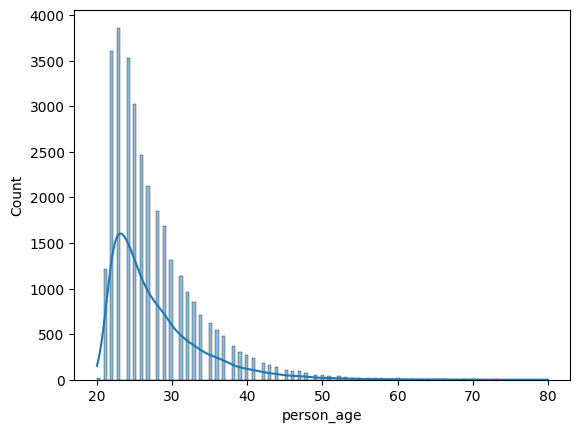

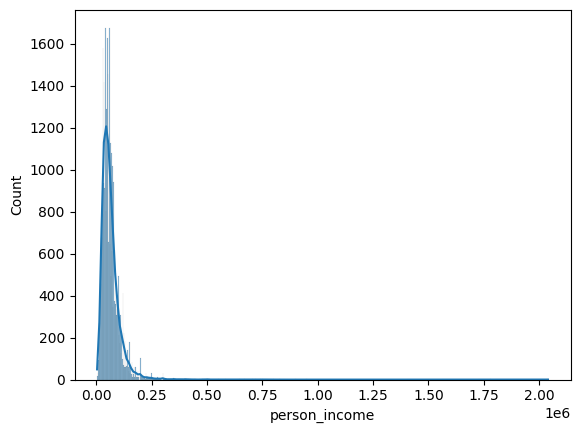

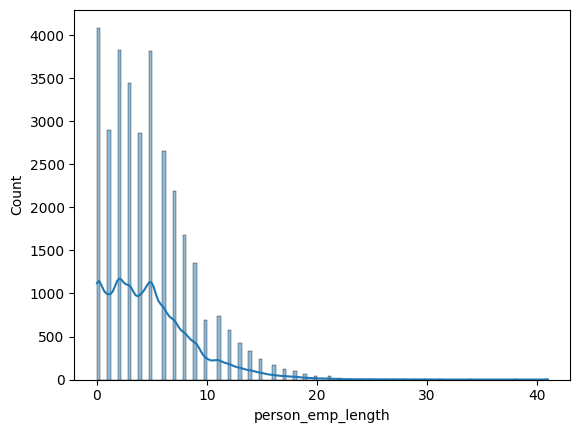

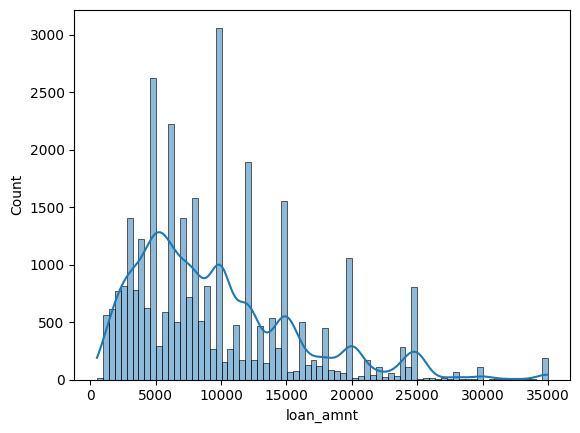

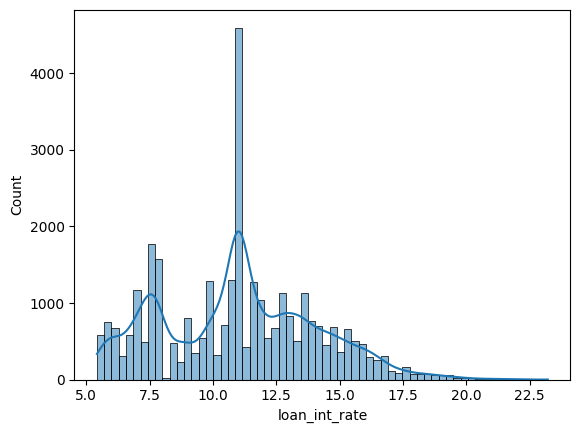

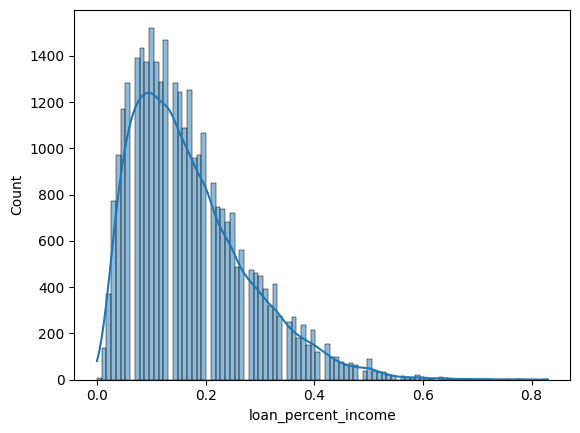

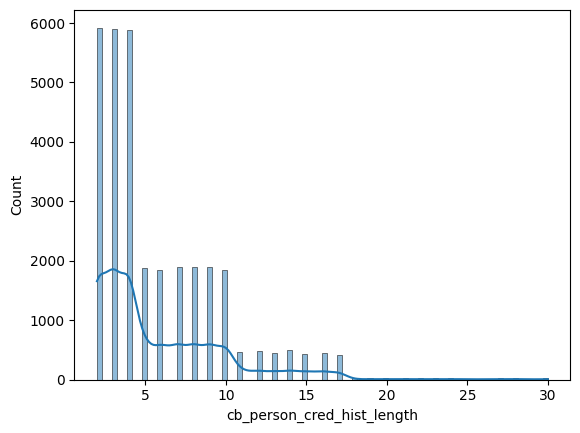

In [16]:
# Data visualization for continuous data
for i in continuous_cols:
    plt.figure()
    sns.histplot(continuous[i],kde=True)

In [17]:
# Features selection for continuous data
for i in continuous_cols:
    print(i)
    logreg = linear_model.LogisticRegression()
    logreg.fit(main_df[[i]],main_df[['loan_status']])
    print(logreg.score(main_df[[i]], main_df[['loan_status']]))
# All features show high correlation with the target 

person_age
0.7812818218286173
person_income
0.7812818218286173
person_emp_length


c:\Users\afiq_\anaconda3\envs\machinelearning\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\afiq_\anaconda3\envs\machinelearning\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\afiq_\anaconda3\envs\machinelearning\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7812818218286173
loan_amnt
0.7812818218286173
loan_int_rate
0.7940259820409171
loan_percent_income
0.8123244977936865
cb_person_cred_hist_length


c:\Users\afiq_\anaconda3\envs\machinelearning\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\afiq_\anaconda3\envs\machinelearning\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\afiq_\anaconda3\envs\machinelearning\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\afiq_\anaconda3\envs\machinelearning\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y 

0.7812818218286173


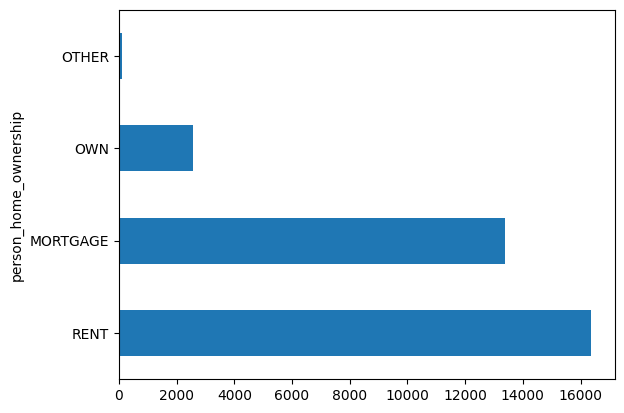

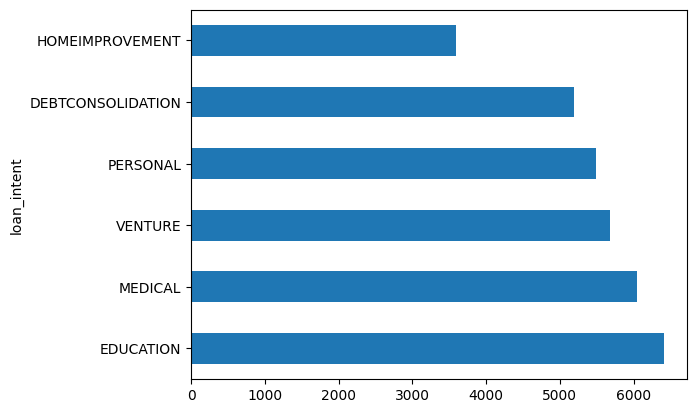

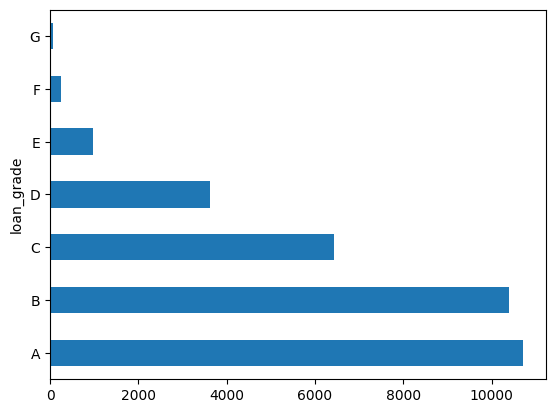

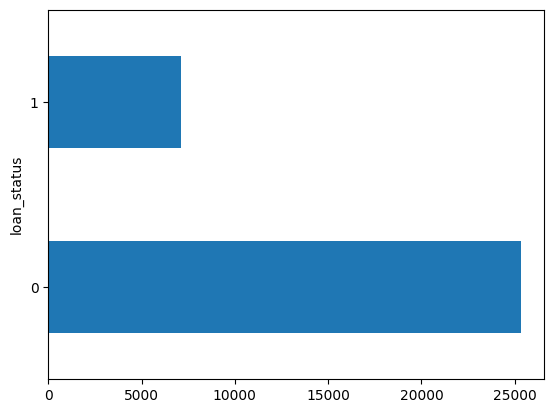

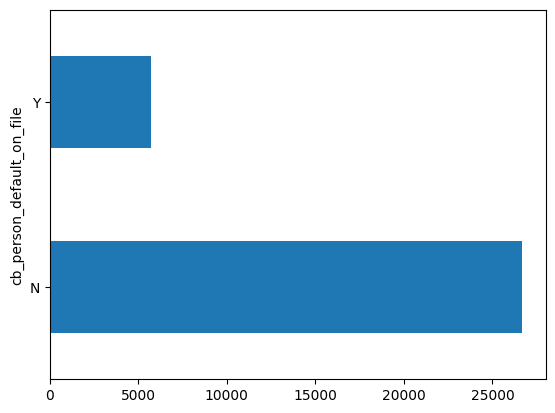

In [18]:
# Data visualization for categorical columns
for i in categorical_cols:
    plt.figure()
    i_count = categorical[i].value_counts()
    i_count.plot(kind='barh')

In [19]:
# Encode categorical columns
categorical_enc = categorical.drop('loan_status',axis=1)
categorical_cols_enc = ['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file']
oe = preprocessing.OrdinalEncoder()
categorical_enc[categorical_cols_enc] = oe.fit_transform(categorical_enc[categorical_cols_enc])
print(categorical_enc)


       person_home_ownership  loan_intent  loan_grade  \
1                        2.0          1.0         1.0   
2                        0.0          3.0         2.0   
3                        3.0          3.0         2.0   
4                        3.0          3.0         2.0   
5                        2.0          5.0         0.0   
...                      ...          ...         ...   
32576                    0.0          4.0         2.0   
32577                    0.0          4.0         0.0   
32578                    3.0          2.0         1.0   
32579                    0.0          4.0         1.0   
32580                    3.0          3.0         1.0   

       cb_person_default_on_file  
1                            0.0  
2                            0.0  
3                            0.0  
4                            1.0  
5                            0.0  
...                          ...  
32576                        0.0  
32577                        0.0  


In [20]:
# Define Cramer V function
def cramers_corrected_stat(confusion_matrix):
    """
    Calculate cramer v statistics for categorical data association
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0,phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r- ((r-1)**2)/(n-1)
    kcorr = k- ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [21]:
# Check correlation between categorical variable and target
for i in categorical_cols_enc:
    print(i)
    matrix = pd.crosstab(categorical[i],categorical['loan_status']).to_numpy()
    print(cramers_corrected_stat(matrix))
# Two categorical features have low correlation with target which is loan_intent and cb_person_default_on_file

person_home_ownership
0.241551928593404
loan_intent
0.12602626949072854
loan_grade
0.4148945077934993
cb_person_default_on_file
0.17905089509570182


In [22]:
# FEATURES SELECTION AND EXTRACTION FOR ML
features = main_df.drop(['loan_intent','cb_person_default_on_file','loan_status'],axis=1)
label = main_df['loan_status']

In [23]:
# DATA PREPROCESSING FOR ML
cols = ['person_home_ownership','loan_grade']
features[cols] = oe.fit_transform(features[cols])
features.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
1,21,9600,2.0,5.0,1.0,1000,11.14,0.10,2
2,25,9600,0.0,1.0,2.0,5500,12.87,0.57,3
3,23,65500,3.0,4.0,2.0,35000,15.23,0.53,2
4,24,54400,3.0,8.0,2.0,35000,14.27,0.55,4
5,21,9900,2.0,2.0,0.0,2500,7.14,0.25,2


In [24]:
# CHECK INFO
print(features.info())

<class 'pandas.core.frame.DataFrame'>
Index: 32407 entries, 1 to 32580
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32407 non-null  int64  
 1   person_income               32407 non-null  int64  
 2   person_home_ownership       32407 non-null  float64
 3   person_emp_length           32407 non-null  float64
 4   loan_grade                  32407 non-null  float64
 5   loan_amnt                   32407 non-null  int64  
 6   loan_int_rate               32407 non-null  float64
 7   loan_percent_income         32407 non-null  float64
 8   cb_person_cred_hist_length  32407 non-null  int64  
dtypes: float64(5), int64(4)
memory usage: 2.5 MB
None


In [25]:
# CHANGES ALL DATA TYPES TO FLOAT
features = features.astype({'person_age':'float64','person_income':'float64',
                            'loan_amnt':'float64','cb_person_cred_hist_length':'float64'})

In [26]:
# RECHECK INFO
print(features.info())

<class 'pandas.core.frame.DataFrame'>
Index: 32407 entries, 1 to 32580
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32407 non-null  float64
 1   person_income               32407 non-null  float64
 2   person_home_ownership       32407 non-null  float64
 3   person_emp_length           32407 non-null  float64
 4   loan_grade                  32407 non-null  float64
 5   loan_amnt                   32407 non-null  float64
 6   loan_int_rate               32407 non-null  float64
 7   loan_percent_income         32407 non-null  float64
 8   cb_person_cred_hist_length  32407 non-null  float64
dtypes: float64(9)
memory usage: 2.5 MB
None


In [27]:
# TRAIN TEST SPLIT
seed = 42
X_train,X_test,y_train,y_test = model_selection.train_test_split(features,label,test_size=0.2,shuffle=True,random_state=seed)

In [28]:
# DEFINE FEATURE SCALER
standard_scaler = preprocessing.StandardScaler()

In [29]:
# MAKE PIPELINES
model_options = [('svc',svm.SVC()),('decision_tree',tree.DecisionTreeClassifier()),('rf',ensemble.RandomForestClassifier()),('knn',neighbors.KNeighborsClassifier())]
pipelines = [pipeline.Pipeline([('scaler',standard_scaler),x]) for x in model_options]
print(pipelines)

[Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC())]), Pipeline(steps=[('scaler', StandardScaler()),
                ('decision_tree', DecisionTreeClassifier())]), Pipeline(steps=[('scaler', StandardScaler()), ('rf', RandomForestClassifier())]), Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsClassifier())])]


In [30]:
# SETUP MLFLOW EXPERIMENTS
# Set the experiments
mlflow.set_experiment("Loan Approval Experiments")

2025/03/26 14:40:51 INFO mlflow.tracking.fluent: Experiment with name 'Loan Approval Experiments' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Folder%20A/Portfolio/Loan_Approval_Status_App/mlruns/155720015465569173', creation_time=1742971251631, experiment_id='155720015465569173', last_update_time=1742971251631, lifecycle_stage='active', name='Loan Approval Experiments', tags={}>

In [31]:
# Run experiments with all the pipelines
for p in pipelines:
    with mlflow.start_run() as run:
        mlflow.sklearn.autolog()
        p.fit(X_train,y_train)
        y_pred = p.predict(X_test)
        accuracy = metrics.accuracy_score(y_test,y_pred)